**<center><font size=5>Brain Tumor Detection with VGG-16 Model</font></center>**
***
**Author**: Navnitan || Ilanggkumaran

**Date**: 30th Nov, 2021

**Table of Contents**
- <a href='#imports'>1. Project Imports and Setting up the Environment</a> 
- <a href='#data'>2. Data Import and Preperation</a>
- <a href='#pre'>3. Preprocessing</a>
    - <a href='#filter'>3.1 Filter </a>
    - <a href='#hist'>3.2 CLAHE and Histogram Equalizer </a>
    - <a href='#dil'>3.3 Dilation and Erosion </a>
    - <a href = "#crop"> 3.4 Cropping </a>
        - <a href = "#crop + filter"> 3.4.1 Crop + Filter + CLAHE </a>
    - <a href='#pipe'>3.5 Preprocessing Pipeline </a>
- <a href='#aug'>4. Data Augmentation</a>
- <a href='#conv'>5. CNN Model</a>
- <a href='#train'>6. Training</a>
    - <a href = "#1"> 6.1 Without Preprocessing </a>
    - <a href = "#2"> 6.2 Only with Histogram equalization </a> 
    - <a href = "#3"> 6.3 Only with CLAHE </a>
    - <a href = "#4"> 6.4 Only with Median filter </a>   
    - <a href = "#5"> 6.5 Only with Gaussian filter </a> 
    - <a href = "#6"> 6.6 Only with Dilation </a>   
    - <a href = "#7"> 6.7 Only with Erosion </a>
    - <a href = "#8"> 6.8 With Median filter + CLAHE </a> 
    - <a href = "#9"> 6.9 With Erosion + CLAHE </a> 
    - <a href = "#10"> 6.10 With Cropped Image </a> 
    - <a href = "#11"> 6.11 With Cropped + Median Image </a>   
    - <a href = "#12"> 6.12 With Cropped + Median + Erosion Image </a>    

### <a id = "import"> 1. Imports </a>

In [2]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend as K
import cv2
import shutil
import glob
import imutils
import warnings
warnings.filterwarnings('ignore')


In [1]:
#Genral library
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import imutils

#Image Preprocessing
from skimage import filters, color
from skimage.morphology import (erosion, dilation, opening, closing,white_tophat, disk)
import cv2
from skimage import exposure
from skimage.morphology import square
from skimage.util import img_as_ubyte
from skimage.morphology import (erosion, dilation, opening, closing,white_tophat)
from skimage.morphology import disk 
from skimage.filters import gaussian,median
from skimage import exposure

#Training 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay


### <a id="data"> 2. Dataset Preparation </a>

In [3]:
data = 'dataset'
no_tumor = 'dataset/no'
yes_tumor = 'dataset/yes'

In [4]:
dirlist=[no_tumor, yes_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [5]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
data = np.array(df)
df.head()

,filepaths,labels
0,dataset/no/31 no.jpg,No
1,dataset/no/38 no.jpg,No
2,dataset/no/N21.jpg,No
3,dataset/no/28 no.jpg,No
4,dataset/no/no 10.jpg,No


The modality of the data set is MRI

| Data | Quantity |
|:-:|:-:|
| With Tumor | 155 |
| Without Tumor | 98 |
| **Total** | **253** |

In [ ]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [7]:
train, test = train_test_split(df, train_size=0.80, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set length: {len(train_new)}")
print(f"test set length: {len(test)}")
print(f"validation set length: {len(valid)}")

train set length: 181
test set length: 51
validation set length: 21


### <a id = "pre"> 3. Image Preprocessing </a>

### <a id = "filter"> 3.1 Filter </a>

The predominant noise in the MRI modality will be Gaussian, Rician and Rayleigh noises. So variety of filters will be tested on the data set and the filter with the highest average PSNR value will be Choosen for prerocessing.

| Filter Type | Average PSNR |
|:-:|:-:|
| NL Mean Filter | 35.048 |
| Median Filter | 36.251 | 
| Mean Filter | 30.401 |
| Bilateral Filter | 32.976 |

In [9]:
def nlmean(img):
    return cv2.fastNlMeansDenoisingColored(img, None,10,10,7,21)

def median(img):
    return filters.median(img)

def mean(img):
    return cv2.medianBlur(img,5)

def bilateral(img):
    return cv2.bilateralFilter(img, 15, 50, 50)

def gaussian_filter(src_img):
    return gaussian(src_img)

def filter_preprocess(process, img):
    if(process == 'gaussian'):
        img1 = gaussian(img)
    elif(process == 'median'):
        img1 = median(img)
    elif(process == 'mean'):
        img1 = mean(img)
    elif(process == 'nlmean'):
        img1 = nlmean(img)
    elif(process == 'bilateral'):
        img1 = bilateral(img)
    else:
        print('Error in filter name')   
    return img1

In [ ]:
filt = ["median", "mean", "nlmean", "bilateral"] 

plt.figure(figsize=(20,20))
j = 0

for fil in filt: 
    psnr = 0
    for i in range(len(df)):
        img = cv2.imread(data[i,0])
        img1 = filter_preprocess(fil, img)
        psnr += cv2.PSNR(img1, img)
        if i == 0:
            print(fil + " " + str(psnr) + " " + "For Image " + data[i, 0])
            plt.subplot(6,7,j+1)
            plt.imshow(img1)
            plt.title(fil)
            plt.xticks([])
            plt.yticks([])
    print(fil + " " + str(round(psnr/len(df), 3)) + " For Average \n")
    j += 1
plt.show()


### <a id = "hist"> 3.2 CLAHE and Histogram Equalizer </a>

Applying CLAHE caused the Accuracy of the algorithm to decrease.

| Filter Type + CLAHE | Average PSNR |
|:-:|:-:|
| NL Mean Filter | 23.515 |
| Median Filter | 22.394 | 
| Mean Filter | 22.247 |
| Bilateral Filter | 23.605 |

In [11]:
def clahe(src_img):
    if(len(src_img.shape) == 3):
        lab = cv2.cvtColor(src_img, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(lab)
        #print(lab_planes.shape)
        a = cv2.createCLAHE(clipLimit = 2.0)
        lab_planes[0] = a.apply(lab_planes[0]) 
        lab = cv2.merge(lab_planes)
        img1 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    else:
        clahe = cv.createCLAHE(clipLimit=5)
        img1 = clahe.apply(src_img)
    return img1

In [12]:
def histogram_equalization(src_img):
    if(len(src_img.shape) == 3):
        (B1, G1, R1) = cv2.split(src_img)
        bgr = []
        for i in (B1, G1, R1):
            equ_img = exposure.equalize_hist(i)
            bgr.append(equ_img)
        merged = cv2.merge(bgr)
    else:
        merged = exposure.equalize_hist(src_img)
    merged = merged.astype(np.uint8)
    return merged

In [ ]:
filt = ["median", "mean", "nlmean", "bilateral"] 

plt.figure(figsize=(20,20))
j = 0
for fil in filt:
    psnr = 0
    psnr1 = 0
    for i in range(len(data)):
        img = cv2.imread(data[i,0])
        img1 = filter_preprocess(fil, img)
        psnr1 += cv2.PSNR(img, img1)
        img1 = clahe(img1)
        psnr += cv2.PSNR(img, img1)
        if i == 0:
            print(fil + " " + str(round(psnr, 3)) + " and " + str(round(psnr1, 3)) + " For Image " + data[i, 0])
            plt.subplot(6,7,j+1)
            plt.title(fil)
            plt.imshow(img1)
            plt.xticks([])
            plt.yticks([])
            #print(img1)
    print(fil + " " + str(round(psnr/len(df), 3)) + " and " + str(round(psnr1/len(df), 3)) + " For Average \n")
    j += 1
plt.show()

In [ ]:
filt = ["median", "mean", "nlmean", "bilateral"] 

plt.figure(figsize=(20,20))
j = 0
for fil in filt:
    psnr = 0
    for i in range(len(df)):
        img = cv2.imread(data[i,0])
        img1 = filter_preprocess(fil, img)
        img1 = histogram_equalization(img1)
        psnr += cv2.PSNR(img, img1)
        if i == 0:
            print(fil + " " + str(psnr) + " " + "For Image " + data[i, 0])
            plt.subplot(6,7,j+1)
            plt.imshow(img1)
            plt.xticks([])
            plt.yticks([])
            #print(img1)
    print(fil + " " + str(round(psnr/len(df), 3)) + " For Average \n")
    j += 1
plt.show()


### <a id = "dil"> 3.3 Erosion and Dilation </a>

In [15]:
def erosion_(src_img):
    (B1, G1, R1) = cv2.split(src_img)
    bgr = []
    for i in (B1, G1, R1):
        equ_img = erosion(i)
        bgr.append(equ_img)
    merged = cv2.merge(bgr)
    return merged

def dilation_(src_img):
    (B1, G1, R1) = cv2.split(src_img)
    bgr = []
    for i in (B1, G1, R1):
        equ_img = dilation(i,disk(3))
        bgr.append(equ_img)
    merged = cv2.merge(bgr)
    return merged

In [ ]:

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(img)
plt.title("Original")
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,2)
plt.imshow(erosion_(img))
plt.title("After Erosion")
plt.xticks([])
plt.yticks([])

plt.show()


In [ ]:

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(img)
plt.title("Original")
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,2)
plt.imshow(dilation_(img))
plt.title("After Dilation")
plt.xticks([])
plt.yticks([])

plt.show()


### <a id = "crop"> 3.4 Cropping </a>

In [18]:
def imgcrop(src_img):
    gray1 = cv2.cvtColor(src_img.copy(), cv2.COLOR_RGB2GRAY)
    gray1 = cv2.GaussianBlur(gray1, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh1 = cv2.threshold(gray1, 45, 255, cv2.THRESH_BINARY)[1]
    thresh1 = cv2.erode(thresh1, None, iterations=2)
    thresh1 = cv2.dilate(thresh1, None, iterations=2)
    thresh1 = thresh1.astype(np.uint8)


    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = 0
    new_img = src_img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    new_img = cv2.resize(
            new_img,
            dsize=(200, 200),
            interpolation=cv2.INTER_CUBIC
        )
    
    return new_img

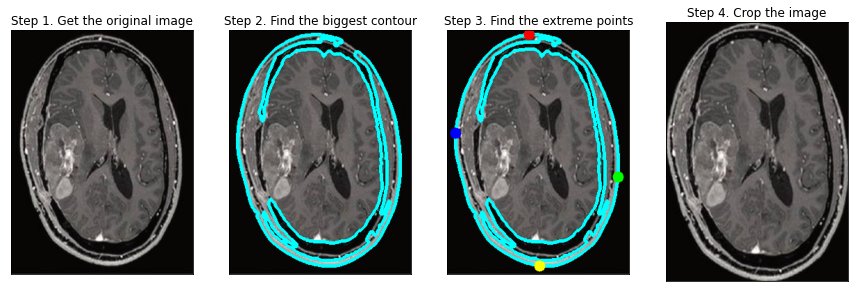

In [19]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    src_img = cv2.imread(df.loc[random,"filepaths"])
    plt.imshow(imgcrop(src_img))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

### <a id = "crop + filter"> 3.4.1 Crop + Filter + CLAHE </a>

In [ ]:
filt = ["median", "mean", "nlmean", "bilateral"] 

plt.figure(figsize=(12,8))
j = 0
for fil in filt:
    psnr = 0
    psnr1 = 0
    for i in range(len(data)):
        img = cv2.imread(data[i,0])
        img1 = imgcrop(img)
        img2 = filter_preprocess(fil, img1)
        psnr1 += cv2.PSNR(img1, img2)
        img2 = clahe(img2)
        psnr += cv2.PSNR(img1, img2)
        if i == 0:
            print(fil + " " + str(round(psnr, 3)) + " and " + str(round(psnr1, 3)) + " For Image " + data[i, 0])
            plt.subplot(3,5,j+1)
            plt.title(fil)
            plt.imshow(img2)
            plt.xticks([])
            plt.yticks([])
            #print(img1)
    print(fil + " " + str(round(psnr/len(df), 3)) + " and " + str(round(psnr1/len(df), 3)) + " For Average \n")
    j += 1
plt.show()

###  <a id = "pipe"> 3.5 Preprocessing Pipeline </a>

In [23]:
def preprocess_pipeline(process, img):
    for pro in process:
        if(pro == 'gaussian'):
            img = gaussian(img)
        elif(pro == 'median'):
            img = median(img)
        elif(pro == 'mean'):
            img = mean(img)
        elif(pro == 'nlmean'):
            img = nlmean(img)
        elif(pro == 'bilateral'):
            img = bilateral(img)
        elif(pro == 'clahe'):
            img = bilateral(img)
        elif(pro == "crop"):
            img = imgcrop(img)
        else:
            print('Error in filter name')   
    return img

In [24]:
def preprocess_wrapper1(img):
    return preprocess_pipeline(processes1,img)

### <a id="aug"> 4. Data Agumentation </a>

In [18]:
def data_aug(preprocess_wrapper):
    train_datagen = ImageDataGenerator(rescale = 1.0/255.0,rotation_range = 15, width_shift_range = 0.05, height_shift_range = 0.05, 
                                   shear_range = 0.05, horizontal_flip = True, vertical_flip =True,preprocessing_function=preprocess_wrapper)
    test_datagen = ImageDataGenerator(rescale = 1.0/255.0 , preprocessing_function=preprocess_wrapper)
    
    RANDOM_SEED = 1234
    
    train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                            x_col = 'filepaths', y_col ='labels',
                                            target_size = (150,150), batch_size = 16, 
                                            class_mode = 'binary', shuffle = True,seed=RANDOM_SEED)
    val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True,seed=RANDOM_SEED)
    test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False,seed=RANDOM_SEED)
    
    return [train_gen,val_gen,test_gen]

### <a id="conv"> 5. Convolutional Nueral Network </a>

In [19]:
def imgnet_model(train_gen,val_gen,model_name):
    base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),include_top=False)
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    
    callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_accuracy', mode='max',verbose=1)]

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy'])

    history = model.fit(train_gen, validation_data = val_gen, epochs = 40, callbacks = [callbacks], verbose = 1)
    
    return [model,history]   

In [20]:
def model_performance(history):
    # plot model performance
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Set')
    plt.plot(epochs_range, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Set')
    plt.plot(epochs_range, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

In [21]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay

def model_report(model,test_gen):
    predictions = model.predict(test_gen)
    predictions = [1 if x>0.5 else 0 for x in predictions]
    

    accuracy = accuracy_score(test_gen.classes, predictions)
    print('Val Accuracy = ' , accuracy)

    print(classification_report(test_gen.classes, predictions))
    
    cm = confusion_matrix(test_gen.classes, predictions) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

### <a id = "train"> 6. Training </a>

### <a id = "1"> 6.1 Without Preprocessing </a>

In [27]:
processes1 = []

In [28]:
def preprocess_wrapper1(img):
    return preprocess_pipeline(processes1,img)

In [29]:
train_gen1,val_gen1,test_gen1 = data_aug(preprocess_wrapper1)
model1,history1 = imgnet_model(train_gen1,val_gen1,'model/model1.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

In [ ]:
model_performance(history1)

Val Accuracy =  0.9411764705882353
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      0.92      0.96        36

    accuracy                           0.94        51
   macro avg       0.92      0.96      0.93        51
weighted avg       0.95      0.94      0.94        51



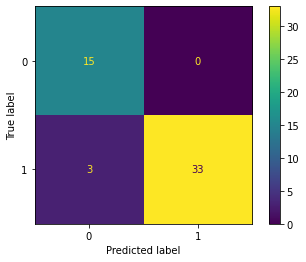

In [31]:
model_report(model1,test_gen1)

### <a id = "2"> 6.2 Only with Histogram equalization </a> 

In [26]:
processes2 = ['histogram equalization']

In [27]:
def preprocess_wrapper2(img):
    return preprocess_pipeline(processes2,img)

In [28]:
train_gen2,val_gen2,test_gen2 = data_aug(preprocess_wrapper2)
model2,history2 = imgnet_model(train_gen2,val_gen2,'model/model2.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

In [ ]:
model_performance(history2)

Val Accuracy =  0.29411764705882354
              precision    recall  f1-score   support

           0       0.29      1.00      0.45        15
           1       0.00      0.00      0.00        36

    accuracy                           0.29        51
   macro avg       0.15      0.50      0.23        51
weighted avg       0.09      0.29      0.13        51



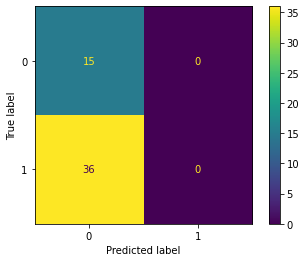

In [30]:
model_report(model2,test_gen2)

### <a id = "3"> 6.3 Only with CLAHE </a>  

In [44]:
processes3 = ['clahe']

In [45]:
def preprocess_wrapper3(img):
    return preprocess_pipeline(processes3,img)

In [46]:
train_gen3,val_gen3,test_gen3 = data_aug(preprocess_wrapper3)
model3,history3 = imgnet_model(train_gen3,val_gen3,'model/model3.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_1019 (Ba (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 

In [ ]:
model_performance(history3)

Val Accuracy =  0.8823529411764706
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.97      0.86      0.91        36

    accuracy                           0.88        51
   macro avg       0.85      0.90      0.87        51
weighted avg       0.90      0.88      0.89        51



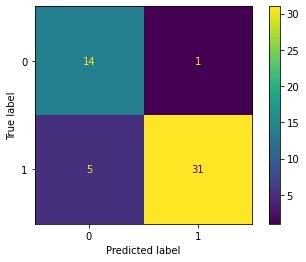

In [48]:
model_report(model3,test_gen3)

### <a id = "4"> 6.4 Only with Median filter </a>   

In [21]:
processes4 = ['median filter']

In [22]:
def preprocess_wrapper4(img):
    return preprocess_pipeline(processes4,img)

In [23]:
train_gen4,val_gen4,test_gen4 = data_aug(preprocess_wrapper4)
model4,history4 = imgnet_model(train_gen4,val_gen4,'model/model4.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (D

In [ ]:
model_performance(history4)

Val Accuracy =  0.9215686274509803
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.92      0.97      0.95        36

    accuracy                           0.92        51
   macro avg       0.92      0.89      0.90        51
weighted avg       0.92      0.92      0.92        51



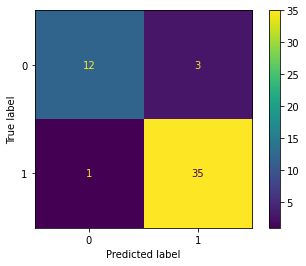

In [25]:
model_report(model4,test_gen4)

### <a id = "5"> 6.5 Only with Gaussian filter </a>    

In [26]:
processes5 = ['gaussian filter']

In [27]:
def preprocess_wrapper5(img):
    return preprocess_pipeline(processes5,img)

In [28]:
train_gen5,val_gen5,test_gen5 = data_aug(preprocess_wrapper5)
model5,history5 = imgnet_model(train_gen5,val_gen5,'model/model5.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

In [ ]:
model_performance(history5)

Val Accuracy =  0.9607843137254902
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      0.94      0.97        36

    accuracy                           0.96        51
   macro avg       0.94      0.97      0.95        51
weighted avg       0.97      0.96      0.96        51



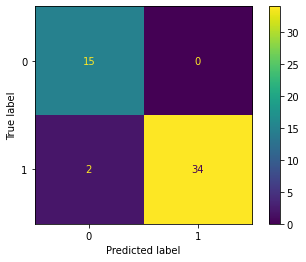

In [30]:
model_report(model5,test_gen5)

### <a id = "6"> 6.6 Only with Dilation </a>     

In [31]:
processes6 = ['dilation']

In [32]:
def preprocess_wrapper6(img):
    return preprocess_pipeline(processes6,img)

In [33]:
train_gen6,val_gen6,test_gen6 = data_aug(preprocess_wrapper6)
model6,history6 = imgnet_model(train_gen6,val_gen6,'model/model6.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_611 (Bat (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 

In [ ]:
model_performance(history6)

Val Accuracy =  0.9019607843137255
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       1.00      0.86      0.93        36

    accuracy                           0.90        51
   macro avg       0.88      0.93      0.89        51
weighted avg       0.93      0.90      0.91        51



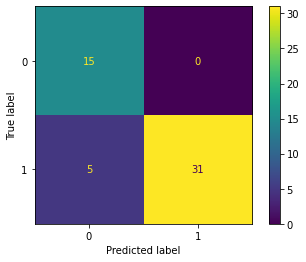

In [35]:
model_report(model6,test_gen6)

### <a id = "7"> 6.7 Only with Erosion </a>

In [ ]:
processes7 = ['erosion']

In [ ]:
def preprocess_wrapper7(img):
    return preprocess_pipeline(processes7,img)

In [39]:
train_gen7,val_gen7,test_gen7 = data_aug(preprocess_wrapper7)
model7,history7 = imgnet_model(train_gen7,val_gen7,'model/model7.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

In [ ]:
model_performance(history7)

Val Accuracy =  0.9803921568627451
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.97      1.00      0.99        36

    accuracy                           0.98        51
   macro avg       0.99      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51



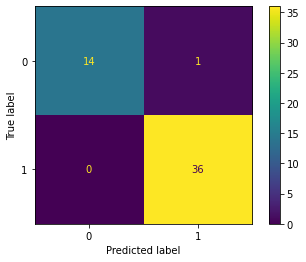

In [41]:
model_report(model7,test_gen7)

### <a id = "8"> 6.8 With Median filter + CLAHE </a> 

In [26]:
processes8 = ['median filter','clahe']

In [27]:
def preprocess_wrapper8(img):
    return preprocess_pipeline(processes8,img)

In [28]:
train_gen8,val_gen8,test_gen8 = data_aug(preprocess_wrapper8)
model8,history8 = imgnet_model(train_gen8,val_gen8,'model/model8.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

In [ ]:
model_performance(history8)

Val Accuracy =  0.9411764705882353
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.97      0.94      0.96        36

    accuracy                           0.94        51
   macro avg       0.92      0.94      0.93        51
weighted avg       0.94      0.94      0.94        51



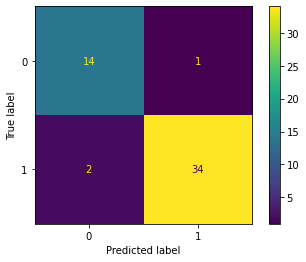

In [30]:
model_report(model8,test_gen8)

### <a id = "9"> 6.9 With Erosion + CLAHE </a> 

In [21]:
processes9 = ['erosion','clahe']

In [22]:
def preprocess_wrapper9(img):
    return preprocess_pipeline(processes9,img)

In [23]:
train_gen9,val_gen9,test_gen9 = data_aug(preprocess_wrapper9)
model9,history9 = imgnet_model(train_gen9,val_gen9,'model/model9.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (D

In [ ]:
model_performance(history9)

Val Accuracy =  0.803921568627451
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        15
           1       1.00      0.72      0.84        36

    accuracy                           0.80        51
   macro avg       0.80      0.86      0.79        51
weighted avg       0.88      0.80      0.81        51



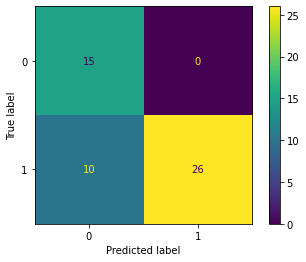

In [25]:
model_report(model9,test_gen9)

### <a id = "10"> 6.10 With Cropped Image </a>  

In [52]:
processes10 = ['crop']

In [54]:
def preprocess_wrapper10(img):
    return preprocess_pipeline(processes10,img)

In [59]:
train_gen10,val_gen10,test_gen10 = data_aug(preprocess_wrapper10)
model10,history10 = imgnet_model(train_gen10,val_gen10,'model/model10.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1536)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               196736    
_________________________________________________________________
batch_normalization_1427 (Ba (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13

In [ ]:
model_performance(history10)

Val Accuracy =  0.9019607843137255
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       1.00      0.86      0.93        36

    accuracy                           0.90        51
   macro avg       0.88      0.93      0.89        51
weighted avg       0.93      0.90      0.91        51



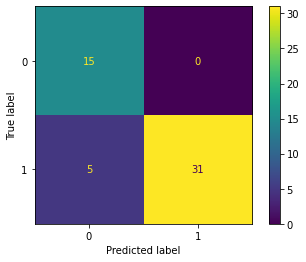

In [61]:
model_report(model10,test_gen10)

### <a id = "11"> 6.11 With Cropped + Median Image </a>   

In [22]:
processes11 = ['crop','median filter']

In [23]:
def preprocess_wrapper11(img):
    return preprocess_pipeline(processes11,img)

In [24]:
train_gen11,val_gen11,test_gen11 = data_aug(preprocess_wrapper11)
model11,history11 = imgnet_model(train_gen11,val_gen11,'model/model11.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (D

In [ ]:
model_performance(history11)

Val Accuracy =  0.9803921568627451
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.97      1.00      0.99        36

    accuracy                           0.98        51
   macro avg       0.99      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51



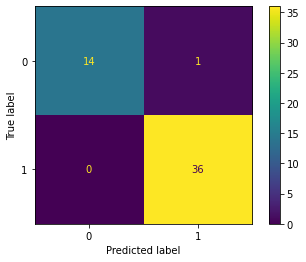

In [26]:
model_report(model11,test_gen11)

### <a id = "12"> 6.12 With Cropped + Median + Erosion Image </a>    

In [27]:
processes12 = ['crop','median filter','erosion']

In [28]:
def preprocess_wrapper12(img):
    return preprocess_pipeline(processes12,img)

In [29]:
train_gen12,val_gen12,test_gen12 = data_aug(preprocess_wrapper12)
model12,history12 = imgnet_model(train_gen12,val_gen12,'model/model12.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

In [ ]:
model_performance(history12)

Val Accuracy =  0.9803921568627451
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.97      1.00      0.99        36

    accuracy                           0.98        51
   macro avg       0.99      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51



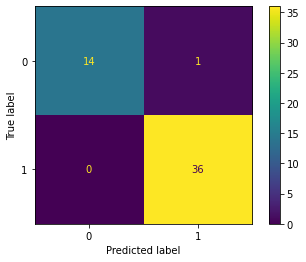

In [31]:
model_report(model11,test_gen12)